In [1]:
#Implicit_opt

In [1]:
import sys
sys.path.append("..")
from geomatry.opt.scipy_optimizer import SingleSystemOptimizer
from geomatry.opt_Energy_approximated.optimizer import SingleSystemOptimizer as SingleSystemOptimizer_Energy
from geomatry.opt.loss import rmsd_loss
from geomatry.ff.graph import get_given_graph_builder
from geomatry.ff.springs import SpringFF, _random_spring_system, _random_spring_ff_param
import torch
import copy

N = 50
N_pairs = 200
max_Za = 3
Ra, Za, idx_i, idx_j = _random_spring_system(N, N_pairs, max_Za, start_Za=1)
k, r0 = _random_spring_ff_param(max_Za, r0_max=5, k_max=5)
ff = SpringFF(max_Za)
ff.reset_parameters(k, r0)

fixed_atom_indices = [0, 1, 2]
graph_builder = get_given_graph_builder(idx_i, idx_j)

# start implicit optimization
params_star = ff.state_dict()
print("params_star", params_star)
optimizer = SingleSystemOptimizer(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)

optimizer_Energy = SingleSystemOptimizer_Energy(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)

k_perturbed = -k.clone() + 3*torch.randn_like(k)
r0_perturbed = torch.clamp(r0.clone() + torch.randn_like(r0) * 3, min=0)

ff.reset_parameters(k_perturbed, r0_perturbed)
params_0 = ff.state_dict()
params_0_old = copy.deepcopy(params_0)

params_star OrderedDict([('k', tensor([[4.1057, 2.2855, 3.5369, 1.7201],
        [2.2855, 2.5185, 1.0952, 3.4206],
        [3.5369, 1.0952, 3.5744, 4.0010],
        [1.7201, 3.4206, 4.0010, 4.1400]], dtype=torch.float64)), ('r0', tensor([[2.9393, 3.5331, 2.3238, 2.6494],
        [3.5331, 4.9753, 1.0945, 3.1512],
        [2.3238, 1.0945, 1.6154, 2.9296],
        [2.6494, 3.1512, 2.9296, 4.8429]], dtype=torch.float64))])


In [4]:
print("params_0", params_0)
new_params_0=optimizer.optimize(params_0)
print("params_optimized",new_params_0)

params_0 OrderedDict([('k', tensor([[-3.3434, -1.6130, -5.1742,  1.9044],
        [-1.6130,  1.8157, -1.7298, -1.5548],
        [-5.1742, -1.7298, -4.1628, -6.3073],
        [ 1.9044, -1.5548, -6.3073, -1.8905]], dtype=torch.float64)), ('r0', tensor([[1.9670, 3.9533, 1.7465, 4.1016],
        [3.9533, 6.5508, 4.0438, 5.0421],
        [1.7465, 4.0438, 3.9792, 3.7373],
        [4.1016, 5.0421, 3.7373, 7.8120]], dtype=torch.float64))])
loss: 19.465506194490075
loss: 18.379331452503653
loss: 15.304059278395277
loss: 20.72626947511023
loss: 14.743572973933633
loss: 19.817220502272644


KeyboardInterrupt: 

In [5]:
#Confirm
import matplotlib.pyplot as plt

new_params_0['k']=(new_params_0['k']+new_params_0['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_0_old['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(new_params_0['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

NameError: name 'new_params_0' is not defined

In [ ]:
#Energy landscape opt

params_0 OrderedDict([('k', tensor([[-3.3434, -1.6130, -5.1742,  1.9044],
        [-1.6130,  1.8157, -1.7298, -1.5548],
        [-5.1742, -1.7298, -4.1628, -6.3073],
        [ 1.9044, -1.5548, -6.3073, -1.8905]], dtype=torch.float64)), ('r0', tensor([[1.9670, 3.9533, 1.7465, 4.1016],
        [3.9533, 6.5508, 4.0438, 5.0421],
        [1.7465, 4.0438, 3.9792, 3.7373],
        [4.1016, 5.0421, 3.7373, 7.8120]], dtype=torch.float64))])
loss: 19.465506194490075
19.465506194490075


  0%|          | 0/80001 [00:00<?, ?it/s]

0 -11.30230406876469 0.1 tensor(23893.5918, dtype=torch.float64, grad_fn=<AddBackward0>)


/Users/soonhyun/Desktop/GeometryOptimization/Landscape_Fork/GeoMatry_LandscapeBased/GeoMatry_LandscapeBased/demo/../geomatry/opt_Energy_approximated/optimizer.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deviations = torch.tensor(deviations_magnitude,device=self.device,requires_grad=False).float().reshape(eN)


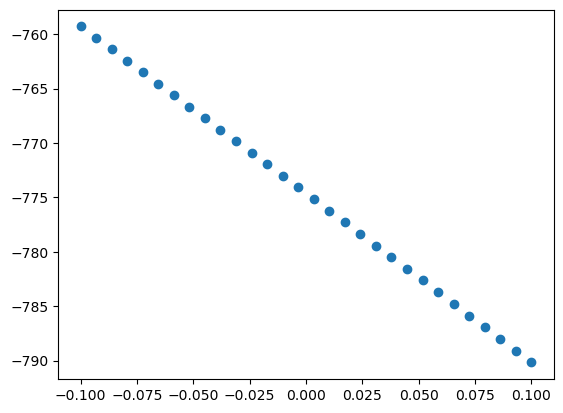

 12%|█▏        | 9982/80001 [00:16<01:54, 612.98it/s]

10000 -4.772955496203654 0.1 tensor(18.1414, dtype=torch.float64, grad_fn=<AddBackward0>)


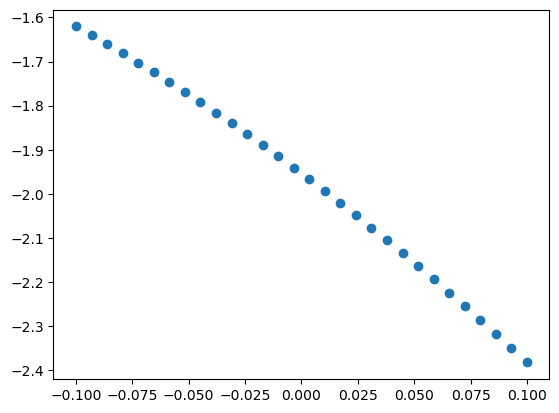

 25%|██▍       | 19949/80001 [00:33<01:39, 606.50it/s]

20000 0.18062263117990884 0.1 tensor(0.0427, dtype=torch.float64, grad_fn=<AddBackward0>)


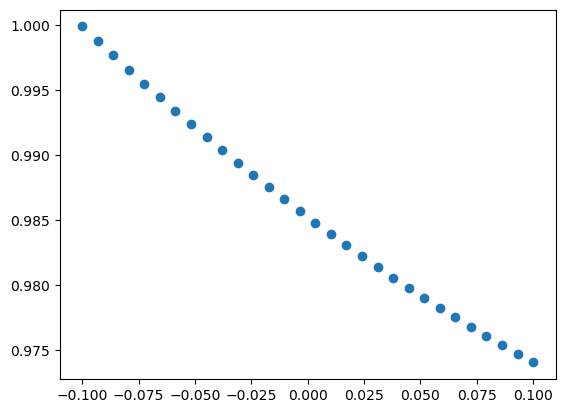

 37%|███▋      | 29973/80001 [00:50<01:20, 619.40it/s]

30000 4.064531626724352 0.1 tensor(0.0046, dtype=torch.float64, grad_fn=<AddBackward0>)


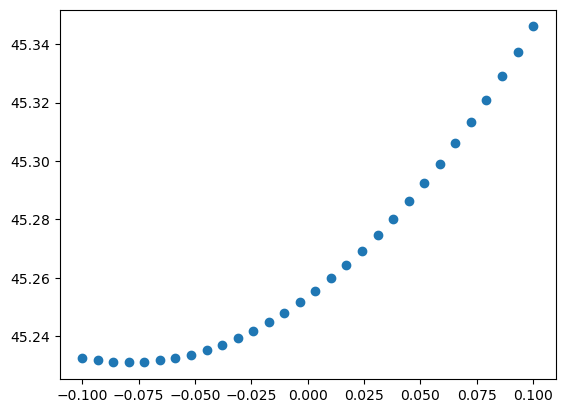

 50%|████▉     | 39958/80001 [01:07<01:05, 612.33it/s]

40000 0.10299910736519045 0.1 tensor(0.1690, dtype=torch.float64, grad_fn=<AddBackward0>)


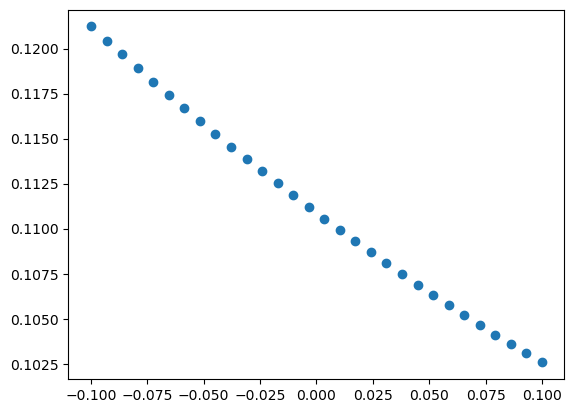

 62%|██████▏   | 49975/80001 [01:25<00:51, 577.51it/s]

50000 3.8305304172621084 0.1 tensor(0.0465, dtype=torch.float64, grad_fn=<AddBackward0>)


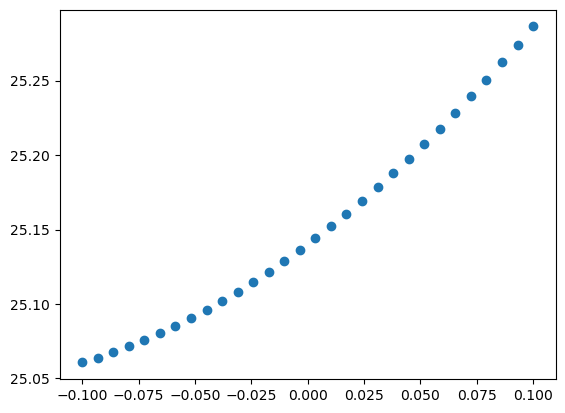

 75%|███████▍  | 59965/80001 [01:42<00:34, 574.25it/s]

60000 4.05026387824038 0.1 tensor(0.0069, dtype=torch.float64, grad_fn=<AddBackward0>)


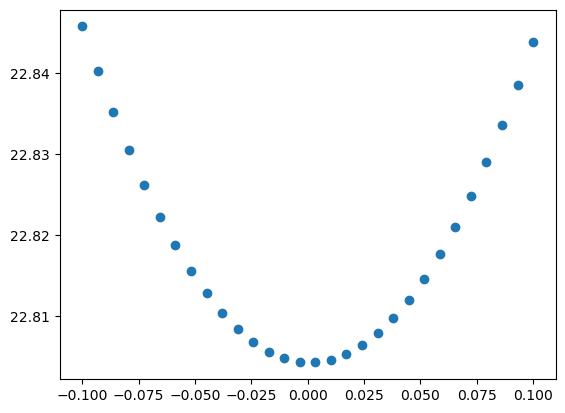

 87%|████████▋ | 69983/80001 [02:00<00:16, 609.18it/s]

70000 5.747705650535864 tensor(0.0870, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(7.8209e-05, dtype=torch.float64, grad_fn=<AddBackward0>)


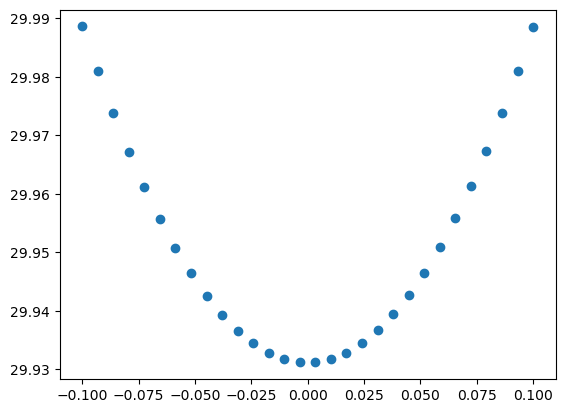

100%|█████████▉| 79992/80001 [02:17<00:00, 609.29it/s]

80000 6.604822668220901 tensor(0.0757, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(1.6099e-05, dtype=torch.float64, grad_fn=<AddBackward0>)


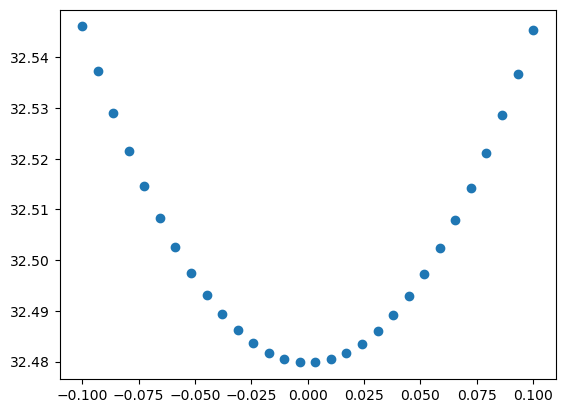

100%|██████████| 80001/80001 [02:17<00:00, 581.45it/s]

final OrderedDict([('k', tensor([[-3.3434, -1.6130, -5.1742,  1.9044],
        [-1.6130,  2.0593,  0.8956,  2.7969],
        [-5.1742,  0.8956,  2.9234,  3.2722],
        [ 1.9044,  2.7969,  3.2722,  3.3854]], dtype=torch.float64)), ('r0', tensor([[1.9670, 3.9533, 1.7465, 4.1016],
        [3.9533, 4.9754, 1.0945, 3.1512],
        [1.7465, 1.0945, 1.6155, 2.9296],
        [4.1016, 3.1512, 2.9296, 4.8430]], dtype=torch.float64))])


In [2]:
def energyAndRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_0", params_0)
    for i in range(1):
        params_0=optimizer.optimize(params_0, 80001, 10000, 0.1, 6, 2)
    return params_0
new_params_0_Energy=energyAndRsquare(k_perturbed, r0_perturbed, optimizer_Energy)


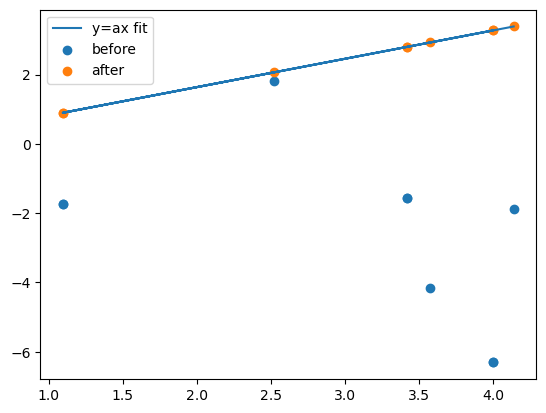

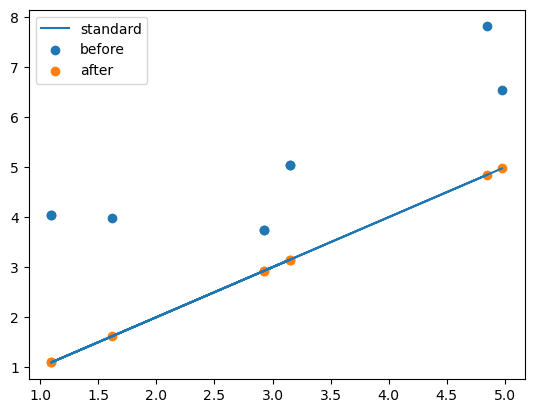

In [3]:
#Confirm
import matplotlib.pyplot as plt

new_params_0_Energy['k']=(new_params_0_Energy['k']+new_params_0_Energy['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0_Energy['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0_Energy['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0_Energy['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()